# Analyize the Serial Killers dataset
Now that the data has been sufficently cleaned, we can begin to analize the data to look for trends.

This notebook has been set up to example specific questions in the data.  I have not asked these in any particular order, so the flow may feel a little jumpy here.  I have done my best to explain the question that I am trying answer, and I have made notes about my findings.

In [34]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# sentiment analysis
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from afinn import Afinn
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# maps
import folium

# Load Data

In [2]:
df = pd.read_csv(r'..\data\serial_killers_wiki_cleaned.csv')

df.head()

,Name,Country,Proven victims,Possible victims,Notes,Start,End,duration,Latitude,Longitude
0,Luis Garavito,Colombia,193,300,"Child-murderer, torture-killer, and rapist kno...",1992,1999,7,4.0,-72.0
1,Pedro López,Colombia,110,300,"Child-murderer and rapist, known as ""The Monst...",1969,1980,11,4.0,-72.0
2,Javed Iqbal,Pakistan,100,100,"Child-murderer and rapist, known as ""Kukri"", I...",1998,1999,1,30.0,70.0
3,Mikhail Popkov,Russia,83,86,"Serial rapist-killer nicknamed ""The Werewolf"",...",1992,2010,18,60.0,100.0
4,Daniel Camargo Barbosa,Colombia,72,180,"Child and woman murderer, believed to have pos...",1974,1986,12,4.0,-72.0


# Basic Visuals and Statistics to Inspect Data

## Start/End/Duration Distributions
The majority of serial killer activity seems to have been in the 80s and 90s.  Most serial killers do not seem to have 

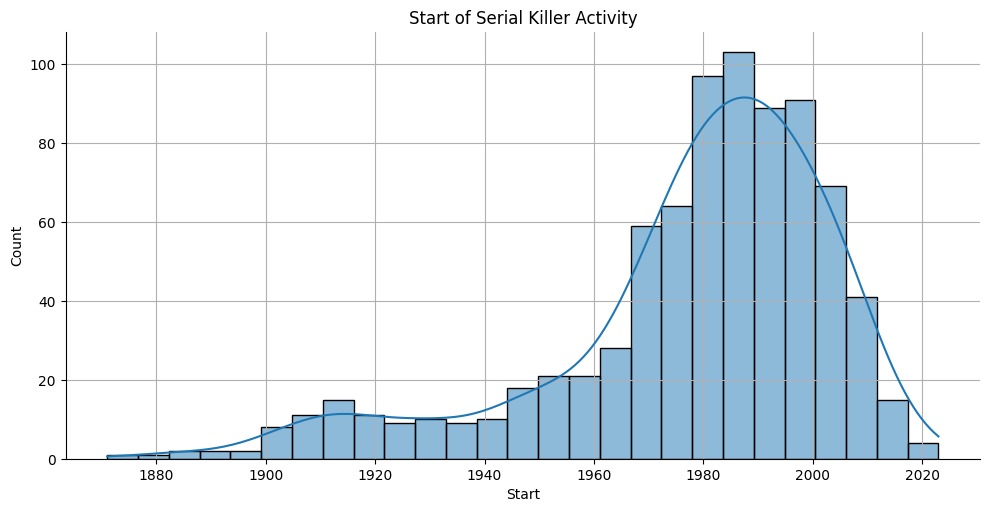

In [3]:
sns.displot(df['Start'], kde=True, height=5, aspect=2)

# plot settings
plt.title('Start of Serial Killer Activity')
plt.grid()

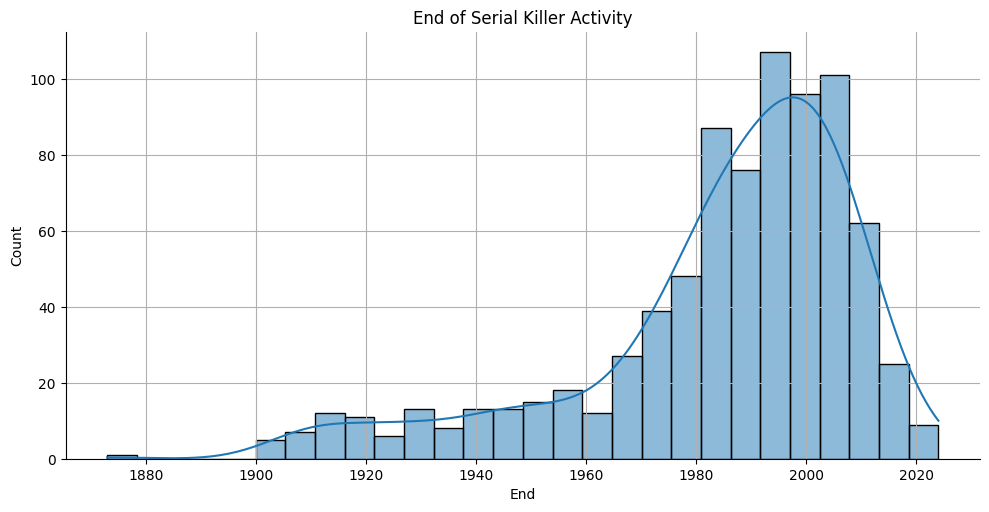

In [4]:
# plot
sns.displot(df['End'], kde=True, height=5, aspect=2)

# plot settings
plt.title('End of Serial Killer Activity')
plt.grid()

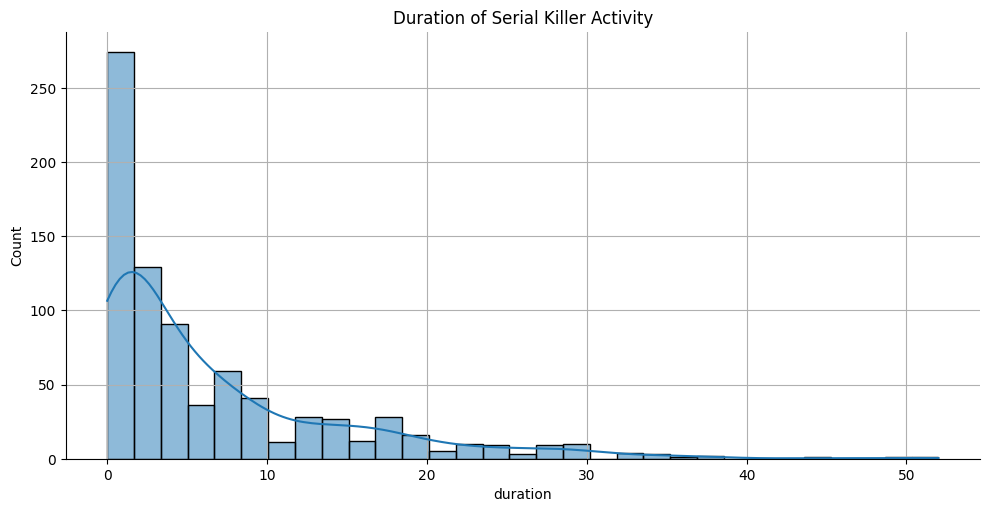

In [5]:
# plot
sns.displot(df['duration'], kde=True, height=5, aspect=2)

# plot settings
plt.title('Duration of Serial Killer Activity')
plt.grid()

# Correlations
None of these correlations are particuarly interesting, and they all make sense on an intuitive level.  

Based on a threshold of +/- .3 for signficance, the only things that stand out are:
* Proven Victims x Possible Victims
    * This makes sense. Some victims may not be proven.  You would expect the number of possible victims to be higher than the proven victims, and not the other way around.  So the more proven victims, the more possible victims there are likely to be. 
* Start x End
    * Again, this makes sense.  You will always see the activity stop after it starts.
* Notable -- duration * start
    * There is a negative correlation here (-.27) which is inside the threshold of +/- .3, meaning that it is not significant.  But this suggests that more recent serial killers will not have a duration that is as long as serial killers of the past.  This could be due to a few things.
        1. The data is catching up - Some of these killers are still active and have not been caught yet, so they are absent in the data.
        2. Presumably, the technology and methods used by law enforcment is getting better over time.  DNA and finger printing techniques for example.  These did not exist in the early 1900s, making it more difficult to capture and convict killers.

In [6]:
df[['Proven victims', 'Possible victims', 'Start', 'End', 'duration']].corr()

,Proven victims,Possible victims,Start,End,duration
Proven victims,1.000000,0.500420,-0.070109,-0.038808,0.107347
Possible victims,0.500420,1.000000,-0.109648,-0.056095,0.182416
Start,-0.070109,-0.109648,1.000000,0.952460,-0.270582
End,-0.038808,-0.056095,0.952460,1.000000,0.035580
duration,0.107347,0.182416,-0.270582,0.035580,1.000000


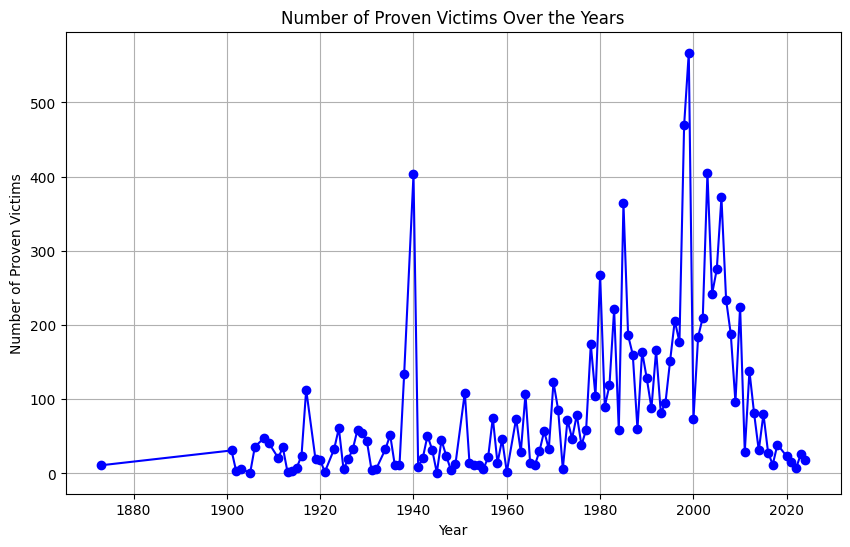

In [7]:
# Group by 'end' and sum 'proven_victims'
victims_per_year = df.groupby('End')['Proven victims'].sum().reset_index()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(victims_per_year['End'], victims_per_year['Proven victims'], marker='o', linestyle='-', color='b')
plt.title('Number of Proven Victims Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Proven Victims')
plt.grid(True)
plt.show()

## Proven Victims by Decade

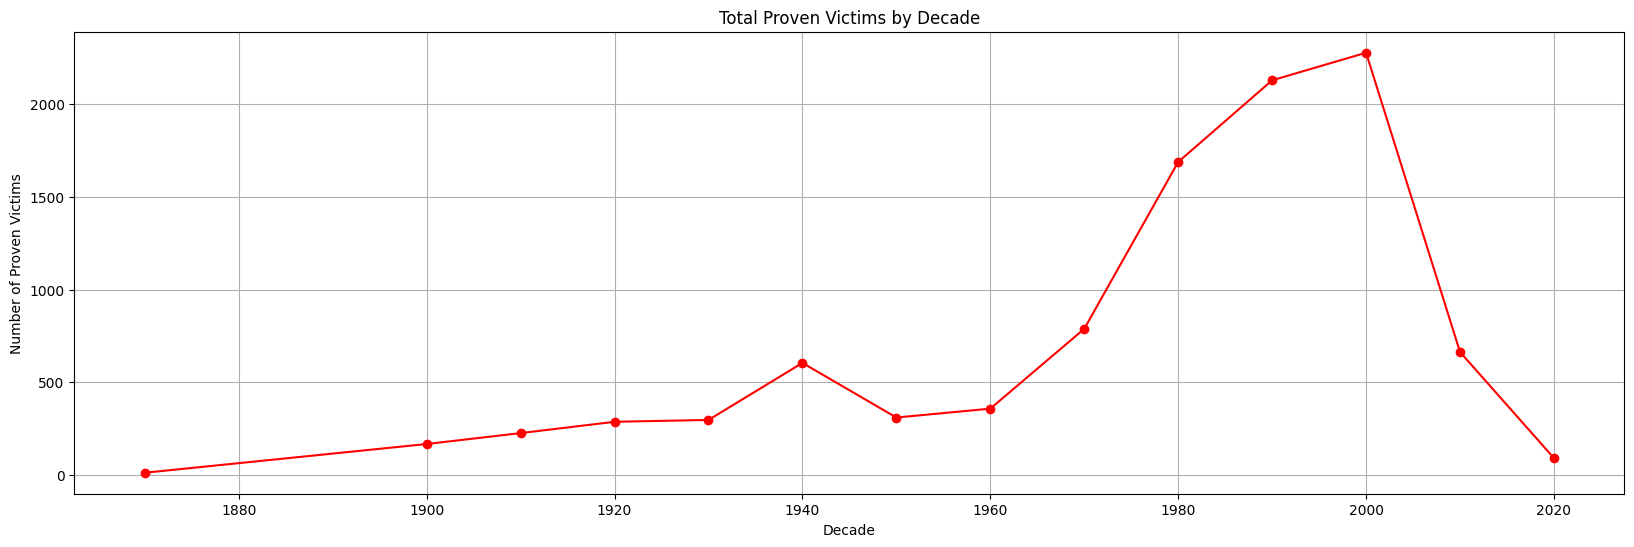

In [8]:
# Ensure that 'End' is converted to numeric (this will turn any non-numeric values into NaN)
df['End'] = pd.to_numeric(df['End'], errors='coerce')

# Now apply the decade calculation (handling NaN values)
df['decade'] = (df['End'].dropna() // 10) * 10

# Group by 'decade' and sum the proven victims
victims_per_decade = df.groupby('decade')['Proven victims'].sum()

# Create plot
plt.figure(figsize=(20,6))
plt.plot(victims_per_decade.index, victims_per_decade.values, marker='o', linestyle='-', color='r')
plt.title('Total Proven Victims by Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Proven Victims')
plt.grid(True)
plt.show()

## 1. Which countries have the most serial killers?
**Note** Only considering first country listed for each serial killer

In [9]:
country_counts = df.value_counts('Country').reset_index()
country_counts.columns = ['Country', 'Count']
country_counts.head()

,Country,Count
0,United States,307
1,United Kingdom,71
2,Russia,32
3,South Africa,29
4,Soviet Union,26


# 2. What 5 Years had the most overlap? 

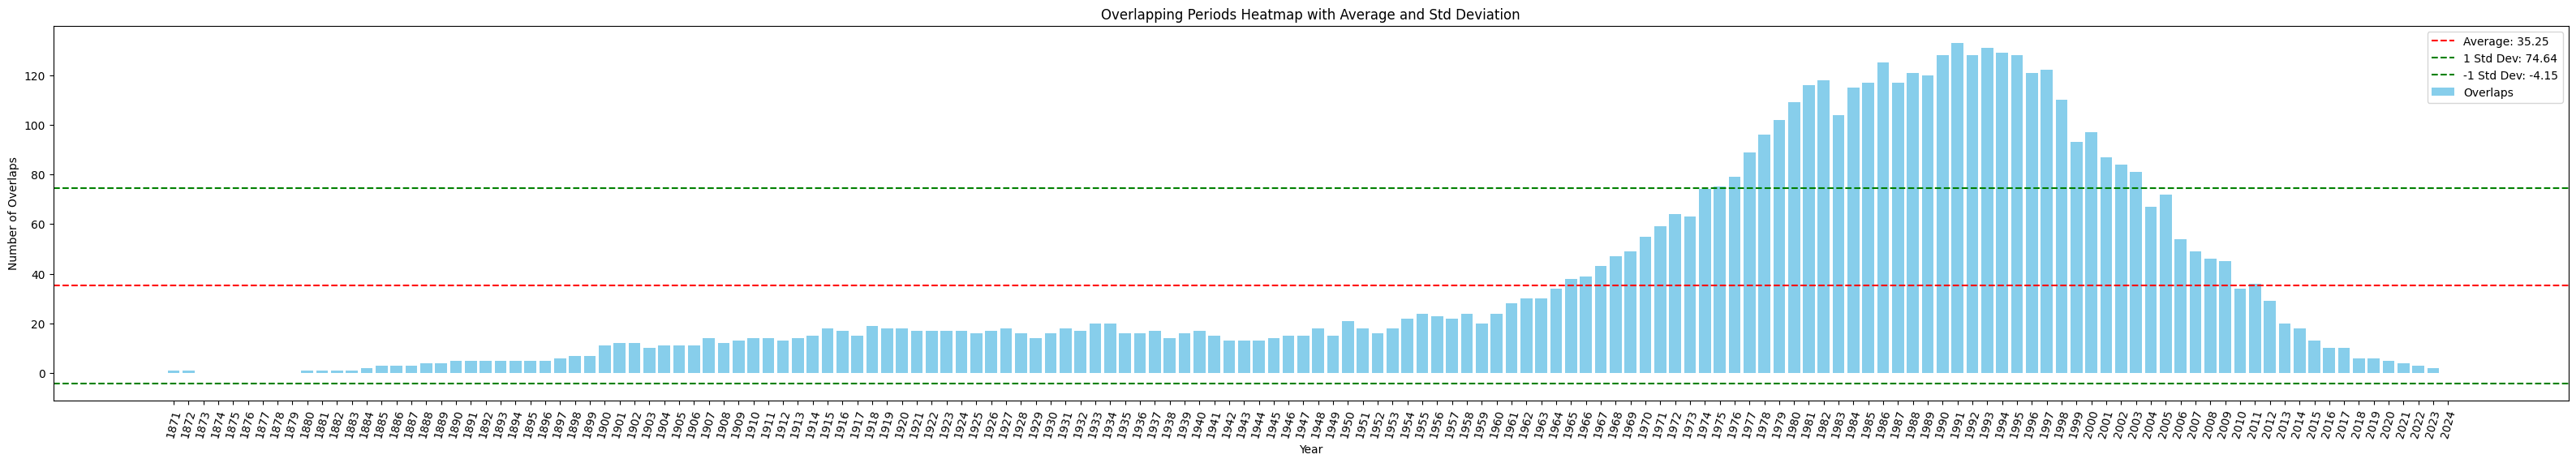

In [10]:
# Convert columns to datetime
df['Start'] = pd.to_datetime(df['Start'], format='%Y')
df['End'] = pd.to_datetime(df['End'], format='%Y')

# Create a date range from the minimum Start to the maximum End
date_range = pd.date_range(df['Start'].min(), df['End'].max(), freq='YS')

# Initialize overlap count array
overlap_counts = np.zeros(len(date_range))

# Count overlaps
for Start, End in zip(df['Start'], df['End']):
    overlap_counts[(date_range >= Start) & (date_range < End)] += 1

# Calculate average and standard deviation
avg_overlaps = np.mean(overlap_counts)
std_dev = np.std(overlap_counts)

# Plot heatmap with average and standard deviation lines
plt.figure(figsize=(40, 6))
plt.bar(date_range.year, overlap_counts, color='skyblue', label='Overlaps')

# Add dotted line for the average
plt.axhline(avg_overlaps, color='red', linestyle='--', label=f'Average: {avg_overlaps:.2f}')

# Add dotted lines for standard deviation (one above and one below the average)
plt.axhline(avg_overlaps + std_dev, color='green', linestyle='--', label=f'1 Std Dev: {avg_overlaps + std_dev:.2f}')
plt.axhline(avg_overlaps - std_dev, color='green', linestyle='--', label=f'-1 Std Dev: {avg_overlaps - std_dev:.2f}')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Number of Overlaps')
plt.title('Overlapping Periods Heatmap with Average and Std Deviation')
plt.xticks(date_range.year, rotation=75)
plt.legend()

# Display the plot
plt.show()

## Top 10 as a table
Note that 1989-1997 are all in the top 10.  1986 is the only year outside of that span.

In [11]:
# Generate a list of years from the minimum Start to the maximum End year
years = list(range(df['Start'].dt.year.min(), df['End'].dt.year.max() + 1))

# Initialize a DataFrame to store the results
active_serial_killers = pd.DataFrame({'year': years})

# Count the number of active serial killers for each year
active_serial_killers['active_serial_killers'] = active_serial_killers['year'].apply(
    lambda year: ((df['Start'].dt.year <= year) & (df['End'].dt.year >= year)).sum()
)

# Display the first few rows of the resulting DataFrame
active_serial_killers.sort_values('active_serial_killers', ascending=False).head(10)

,year,active_serial_killers
120,1991,147
121,1992,147
123,1994,146
122,1993,146
115,1986,146
124,1995,144
125,1996,144
119,1990,143
126,1997,139
118,1989,139


# 3. How many active serial killers are there at any given time? 

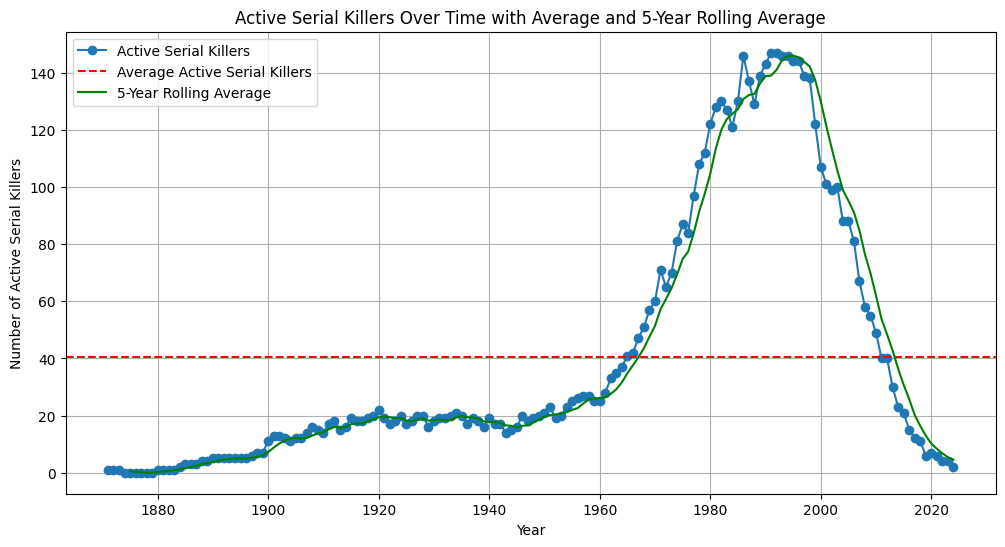

In [12]:

# Calculate the average number of active serial killers across all years
average_active = active_serial_killers['active_serial_killers'].mean()

# Calculate the rolling average based on the previous 5 years
active_serial_killers['rolling_avg'] = active_serial_killers['active_serial_killers'].rolling(window=5).mean()

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(active_serial_killers['year'], active_serial_killers['active_serial_killers'], label='Active Serial Killers', marker='o')
plt.axhline(average_active, color='r', linestyle='--', label='Average Active Serial Killers')
plt.plot(active_serial_killers['year'], active_serial_killers['rolling_avg'], label='5-Year Rolling Average', color='g')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of Active Serial Killers')
plt.title('Active Serial Killers Over Time with Average and 5-Year Rolling Average')
plt.legend()
plt.grid(True)
# Show plot
plt.show()


# How many serial killers are have been active recently?

In [13]:
active_serial_killers.sort_values('year', ascending=False).head(10)

,year,active_serial_killers,rolling_avg
153,2024,2,4.6
152,2023,4,5.4
151,2022,4,6.8
150,2021,6,8.4
149,2020,7,10.2
148,2019,6,13.0
147,2018,11,16.4
146,2017,12,20.2
145,2016,15,25.8
144,2015,21,30.8


# 5. Is there a relationship between Country/Decade/Proven victims?

In [14]:
# Ensure proper date format
df['End'] = df['End'].dt.strftime('%Y')
df['Start'] = df['Start'].dt.strftime('%Y')

# create a new column called 'decade' and assign the decade of the 'End' year to it
df['decade'] = df['End'].astype(int) // 10 * 10
df.head()


,Name,Country,Proven victims,Possible victims,Notes,Start,End,duration,Latitude,Longitude,decade
0,Luis Garavito,Colombia,193,300,"Child-murderer, torture-killer, and rapist kno...",1992,1999,7,4.0,-72.0,1990
1,Pedro López,Colombia,110,300,"Child-murderer and rapist, known as ""The Monst...",1969,1980,11,4.0,-72.0,1980
2,Javed Iqbal,Pakistan,100,100,"Child-murderer and rapist, known as ""Kukri"", I...",1998,1999,1,30.0,70.0,1990
3,Mikhail Popkov,Russia,83,86,"Serial rapist-killer nicknamed ""The Werewolf"",...",1992,2010,18,60.0,100.0,2010
4,Daniel Camargo Barbosa,Colombia,72,180,"Child and woman murderer, believed to have pos...",1974,1986,12,4.0,-72.0,1980


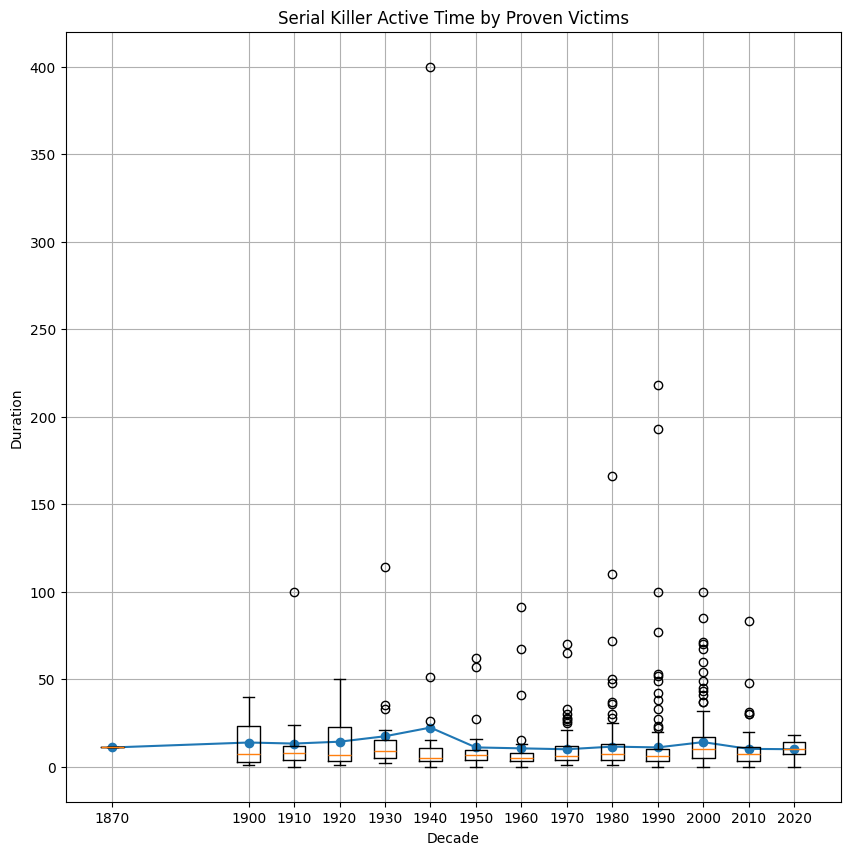

In [15]:
duration_by_decade = df.groupby('decade')['Proven victims'].mean().reset_index()

plt.figure(figsize=(10, 10))
plt.plot(duration_by_decade['decade'], duration_by_decade['Proven victims'], label='Duration', marker='o')
# Create a boxplot for each decade
plt.boxplot(df.groupby('decade')['Proven victims'].apply(list), positions=duration_by_decade['decade'], widths=5)

# Add labels and title
plt.xlabel('Decade')
plt.ylabel('Duration')
plt.title('Serial Killer Active Time by Proven Victims')

# Show plot
plt.grid()
plt.show()

# 6.  Sentiment Analysis
Using sentiment analysis, does anything in the data stand out?  Is there any correlation between the description (`Note`) and how effective a killer is? 

Note - This is extremely succeptable to bias, which is why I have have not included this data in the dashboard visualizations. I fear that this could be misleading as I do not know who wrote these descriptions or what baises/underlying assumptions they were working on when they put together this dataset.

## Text Cleaning
In order to properly analyze this text, some basic works needs to be done to clean.  Here I am only removing stop words and using a basic stemming technique.  This is a simple analysis, so much more could be done here. But this is sufficent for my purposes.

In [16]:

# Required NLTK downloads - only need to run once
# nltk.download('stopwords')
# nltk.download('punkt_tab')

# Initialize stemmer and stop words
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Define a function for preprocessing text (stop words removal and stemming)
def preprocess_text(text):
    # Tokenize and lower text
    tokens = nltk.word_tokenize(text.lower())
    
    # Remove stop words and apply stemming
    processed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    # Rejoin tokens into a string
    return ' '.join(processed_tokens)

In [17]:
# Ensure Notes column is a string or replace NaN with an empty string
df['Notes'] = df['Notes'].fillna('').astype(str)

# Preprocess the 'Notes' column
df['Cleaned_Notes'] = df['Notes'].apply(preprocess_text)

# afinn sentiment analysis
afinn = Afinn()
df['AFINN'] = df['Cleaned_Notes'].apply(afinn.score)

# textblob sentiment analysis
df['TextBlob'] = df['Cleaned_Notes'].apply(lambda x: TextBlob(x).sentiment.polarity)

# vader sentiment analysis
analyzer = SentimentIntensityAnalyzer()
df['VADER'] = df['Cleaned_Notes'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

df.head()

,Name,Country,Proven victims,Possible victims,Notes,Start,End,duration,Latitude,Longitude,decade,Cleaned_Notes,AFINN,TextBlob,VADER
0,Luis Garavito,Colombia,193,300,"Child-murderer, torture-killer, and rapist kno...",1992,1999,7,4.0,-72.0,1990,"child-murder , torture-kil , rapist known `` l...",-27.0,-0.012500,-0.9816
1,Pedro López,Colombia,110,300,"Child-murderer and rapist, known as ""The Monst...",1969,1980,11,4.0,-72.0,1980,"child-murder rapist , known `` monster and '' ...",-14.0,-0.037500,-0.9719
2,Javed Iqbal,Pakistan,100,100,"Child-murderer and rapist, known as ""Kukri"", I...",1998,1999,1,30.0,70.0,1990,"child-murder rapist , known `` kukri '' , iqba...",-25.0,-0.050000,-0.9889
3,Mikhail Popkov,Russia,83,86,"Serial rapist-killer nicknamed ""The Werewolf"",...",1992,2010,18,60.0,100.0,2010,"serial rapist-kil nicknam `` werewolf '' , act...",-18.0,-0.037500,-0.9661
4,Daniel Camargo Barbosa,Colombia,72,180,"Child and woman murderer, believed to have pos...",1974,1986,12,4.0,-72.0,1980,"child woman murder , believ possibl rape kill ...",-31.0,-0.045833,-0.9933


## Correlations
Nothing of statistical signficance

In [18]:
df[['Proven victims', 'Possible victims', 'duration', 'AFINN', 'TextBlob', 'VADER']]\
    .corr()[['AFINN', 'TextBlob', 'VADER']]

,AFINN,TextBlob,VADER
Proven victims,-0.120332,-0.062724,-0.040097
Possible victims,-0.130783,-0.013576,-0.054922
duration,-0.148051,0.004282,-0.063819
AFINN,1.000000,0.119816,0.561923
TextBlob,0.119816,1.000000,0.067977
VADER,0.561923,0.067977,1.000000


# Overall Sentiments
Overall, the sentiments are negavtive, which makes sense given we are discussing a rather mcabe topic.

The `VADER` is extremely negative, but it is worth cavaeting that this tool was developed for social media analysis, so while it is userful, it should be taken with a grain of salt.

In [19]:
df[['AFINN', 'TextBlob', 'VADER']].mean()

AFINN      -7.128237
TextBlob   -0.028524
VADER      -0.832719
dtype: float64

In [1]:
df.head()


NameError: name 'df' is not defined

# 7. Map
I've left the code here, commented out.  I am not confident the coordinates are right based on how it rendered.  I may return to this at some point.

In [29]:
# valid_data = df.dropna(subset=['Latitude', 'Longitude'])

# # Initialize a base map centered around the average Latitude and Longitude
# m = folium.Map(location=[valid_data['Latitude'].mean(), valid_data['Longitude'].mean()], zoom_start=2)

# # Function to add markers for each killer
# for _, row in valid_data.iterrows():
#     folium.CircleMarker(
#         location=(row['Latitude'], row['Longitude']),
#         radius=row['Proven victims'] * 0.1,  # Adjust the scale factor as needed
#         color='red',
#         fill=True,
#         fill_color='red',
#         fill_opacity=0.6,
#         popup=f"Killer: {row['Name']}\nProven Victims: {row['Proven victims']}\nCountry: {row['Country']}"
#     ).add_to(m)

# # Save the map to an HTML file and display it
# m.save('../data/serial_killer_map.html')
# m